# Notebook 1.0 - Tiền xử lý âm thanh

## Cell 1: Import các thư viện cần thiết
Cell này import các thư viện cần thiết cho quá trình xử lý âm thanh:
- `os`: để thao tác với đường dẫn file
- `numpy`: để xử lý mảng và tính toán
- `noisereduce`: để giảm nhiễu trong âm thanh
- `scipy.io.wavfile`: để đọc/ghi file WAV
- `pydub`: để xử lý âm thanh ở mức cao
- `librosa`: thư viện chính để xử lý âm thanh
- `matplotlib` và `librosa.display`: để hiển thị đồ thị

In [11]:
import os
import numpy as np
import noisereduce as nr
from scipy.io import wavfile
from pydub import AudioSegment
import librosa
import matplotlib.pyplot as plt
import librosa.display

## Cell 2: Định nghĩa class AudioPreprocessor
Class này chứa các phương thức để xử lý âm thanh:
- `__init__`: Khởi tạo với tần số lấy mẫu mục tiêu là 16kHz
- `load_audio`: Tải và chuyển đổi âm thanh về mono 16kHz
- `denoise`: Giảm nhiễu trong âm thanh
- `extract_one_second`: Trích xuất 1 giây có năng lượng cao nhất
- `normalize_audio`: Chuẩn hóa âm thanh về biên độ [-1, 1]
- `process_audio_file`: Pipeline xử lý chính, kết hợp tất cả các bước trên

In [12]:
class AudioPreprocessor:
    def __init__(self):
        self.target_sr = 16000
        
    def load_audio(self, input_path):
        """Load and convert audio to mono 16kHz"""
        audio = AudioSegment.from_wav(input_path).set_channels(1).set_frame_rate(self.target_sr)
        raw_audio = np.array(audio.get_array_of_samples())
        rate = audio.frame_rate
        return raw_audio, rate
        
    def denoise(self, audio, sr):
        """Apply noise reduction"""
        denoised = nr.reduce_noise(y=audio.astype(np.float32), sr=sr)
        if sr != self.target_sr:
            denoised = librosa.resample(denoised, orig_sr=sr, target_sr=self.target_sr)
        return denoised, self.target_sr
        
    def extract_one_second(self, audio, sr):
        """Extract 1 second with highest energy"""
        segment_len = int(1.0 * sr)
        stride = int(0.02 * sr)

        max_energy = 0
        best_start = 0
        for i in range(0, len(audio) - segment_len + 1, stride):
            window = audio[i:i + segment_len]
            energy = np.sum(window.astype(np.float32) ** 2)
            if energy > max_energy:
                max_energy = energy
                best_start = i

        return audio[best_start:best_start + segment_len]
        
    def normalize_audio(self, audio):
        """Apply peak normalization"""
        max_val = np.max(np.abs(audio))
        if max_val > 0:
            audio = audio / max_val * 0.99
        return (audio * 32767).astype(np.int16)
        
    def process_audio_file(self, input_path):
        """Main processing pipeline"""
        # Load audio
        raw_audio, rate = self.load_audio(input_path)
        
        # Denoise
        denoised_audio, rate = self.denoise(raw_audio, rate)
        
        # Get 1 second segment
        one_sec_segment = self.extract_one_second(denoised_audio, rate)
        
        # Normalize
        final_output = self.normalize_audio(one_sec_segment)
        
        return final_output, rate

## Cell 3: Hàm visualize_processing_steps
Hàm này hiển thị trực quan từng bước xử lý âm thanh:
- Hiển thị 4 đồ thị: waveform gốc, sau khi giảm nhiễu, đoạn 1 giây, và mel spectrogram cuối cùng
- In thông tin về file: đường dẫn, độ dài gốc, độ dài cuối, tần số lấy mẫu
- Phân tích năng lượng: năng lượng gốc, năng lượng cuối, tỷ lệ năng lượng

In [13]:
def visualize_processing_steps(input_path):
    """
    Visualize each step of audio processing
    """
    processor = AudioPreprocessor()
    
    # Load audio
    raw_audio, rate = processor.load_audio(input_path)
    
    # Denoise
    denoised_audio, rate = processor.denoise(raw_audio, rate)
    
    # Get 1 second segment
    one_sec_segment = processor.extract_one_second(denoised_audio, rate)
    
    # Normalize
    final_output = processor.normalize_audio(one_sec_segment)
    
    # Create figure with 4 subplots
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    # 1. Original waveform
    librosa.display.waveshow(raw_audio.astype(np.float32)/32767, sr=rate, ax=axes[0])
    axes[0].set_title('Original Audio Waveform')
    axes[0].set_xlabel('')
    
    # 2. Waveform after noise reduction
    librosa.display.waveshow(denoised_audio, sr=rate, ax=axes[1])
    axes[1].set_title('After Noise Reduction')
    axes[1].set_xlabel('')
    
    # 3. 1s segment waveform
    librosa.display.waveshow(one_sec_segment, sr=rate, ax=axes[2])
    axes[2].set_title('1 Second Segment')
    axes[2].set_xlabel('')
    
    # 4. Final mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=final_output.astype(np.float32)/32767, sr=rate)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_spec_db, sr=rate, ax=axes[3])
    axes[3].set_title('Final Mel Spectrogram')
    
    plt.tight_layout()
    plt.show()
    
    # Print file information
    print(f"File: {input_path}")
    print(f"Original duration: {len(raw_audio)/rate:.2f}s")
    print(f"Final duration: {len(final_output)/rate:.2f}s")
    print(f"Sample rate: {rate}Hz")
    
    # Print energy information
    energy_orig = np.sum(raw_audio.astype(np.float32)**2)
    energy_final = np.sum(final_output.astype(np.float32)**2)
    print(f"\nEnergy analysis:")
    print(f"Original energy: {energy_orig:.2f}")
    print(f"Final energy: {energy_final:.2f}")
    print(f"Energy ratio (Final/Original): {energy_final/energy_orig:.2f}")

## Cell 4: Xử lý và hiển thị kết quả
Cell này thực hiện:
- Duyệt qua các thư mục lệnh trong thư mục raw
- Với mỗi thư mục lệnh, lấy file WAV đầu tiên
- Gọi hàm visualize_processing_steps để hiển thị quá trình xử lý
- In tên thư mục lệnh đang xử lý


Visualizing processing steps for: bat_den


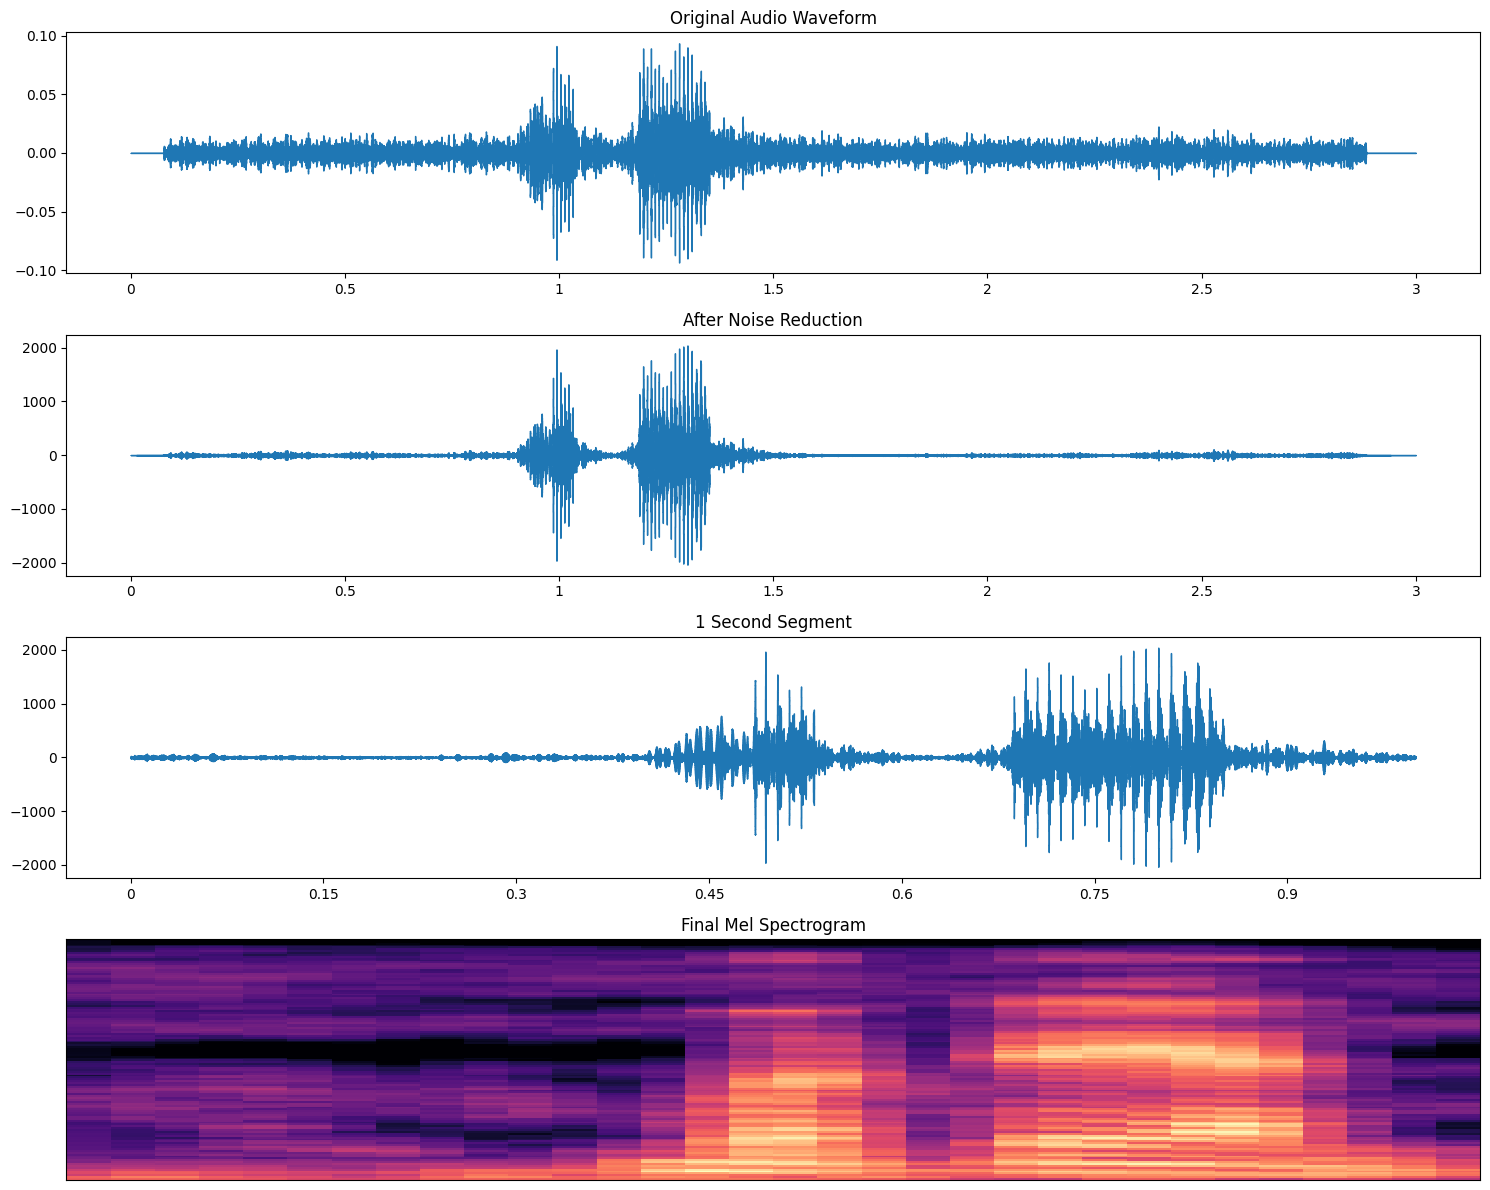

File: ../data/raw/bat_den/bat_den_speaker01_001.wav
Original duration: 3.00s
Final duration: 1.00s
Sample rate: 16000Hz

Energy analysis:
Original energy: 3734743296.00
Final energy: 211706347520.00
Energy ratio (Final/Original): 56.69

Visualizing processing steps for: bat_dieu_hoa


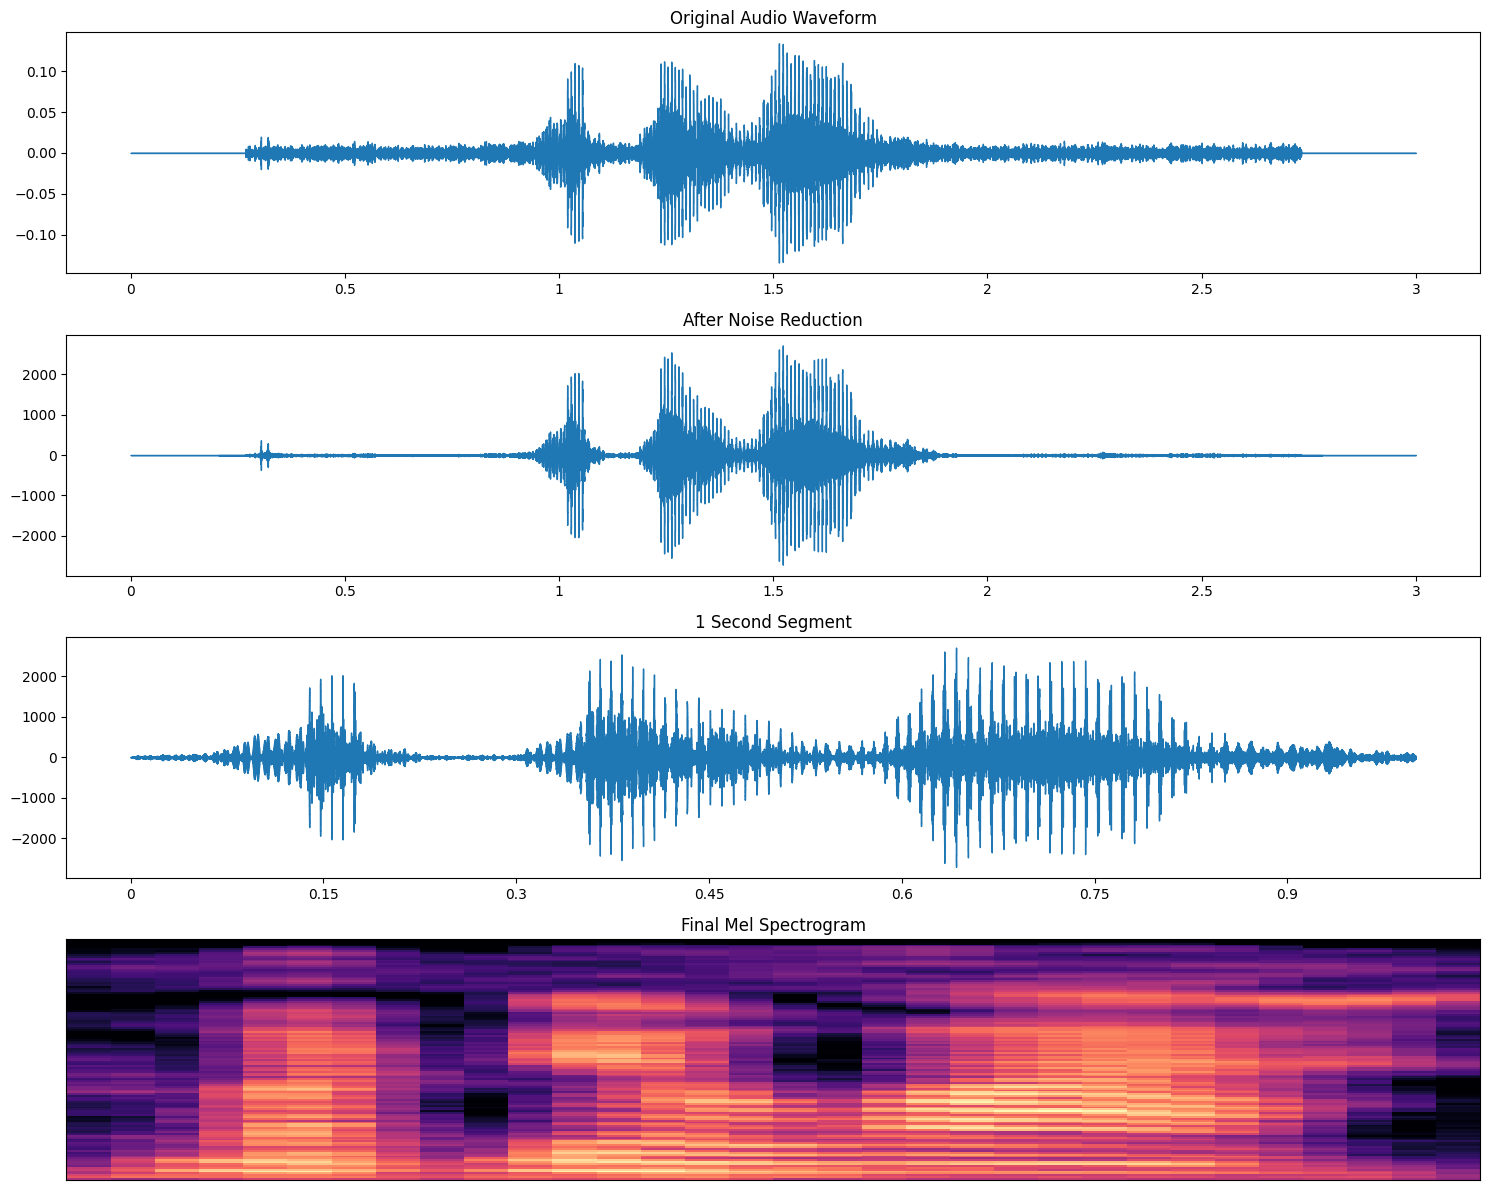

File: ../data/raw/bat_dieu_hoa/bat_dieu_hoa_speaker01_001.wav
Original duration: 3.00s
Final duration: 1.00s
Sample rate: 16000Hz

Energy analysis:
Original energy: 8260879872.00
Final energy: 347372191744.00
Energy ratio (Final/Original): 42.05

Visualizing processing steps for: bat_quat


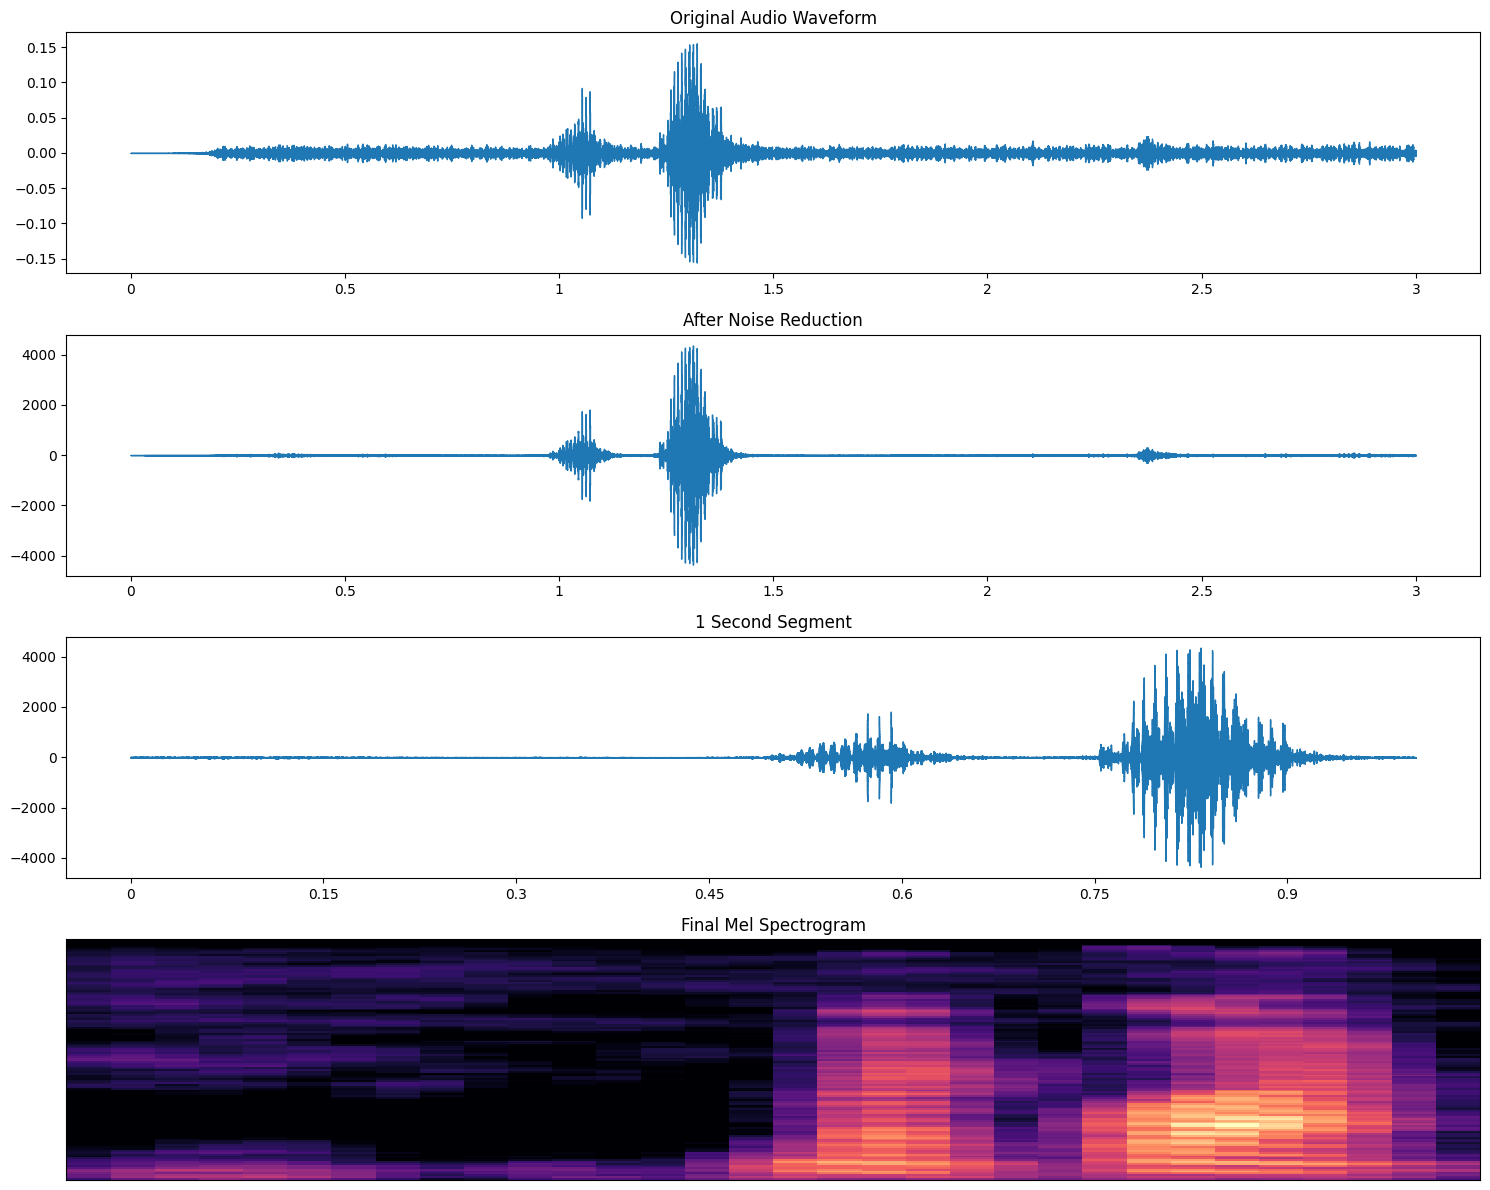

File: ../data/raw/bat_quat/bat_quat_speaker01_001.wav
Original duration: 3.00s
Final duration: 1.00s
Sample rate: 16000Hz

Energy analysis:
Original energy: 5888293376.00
Final energy: 190964695040.00
Energy ratio (Final/Original): 32.43

Visualizing processing steps for: bat_tv


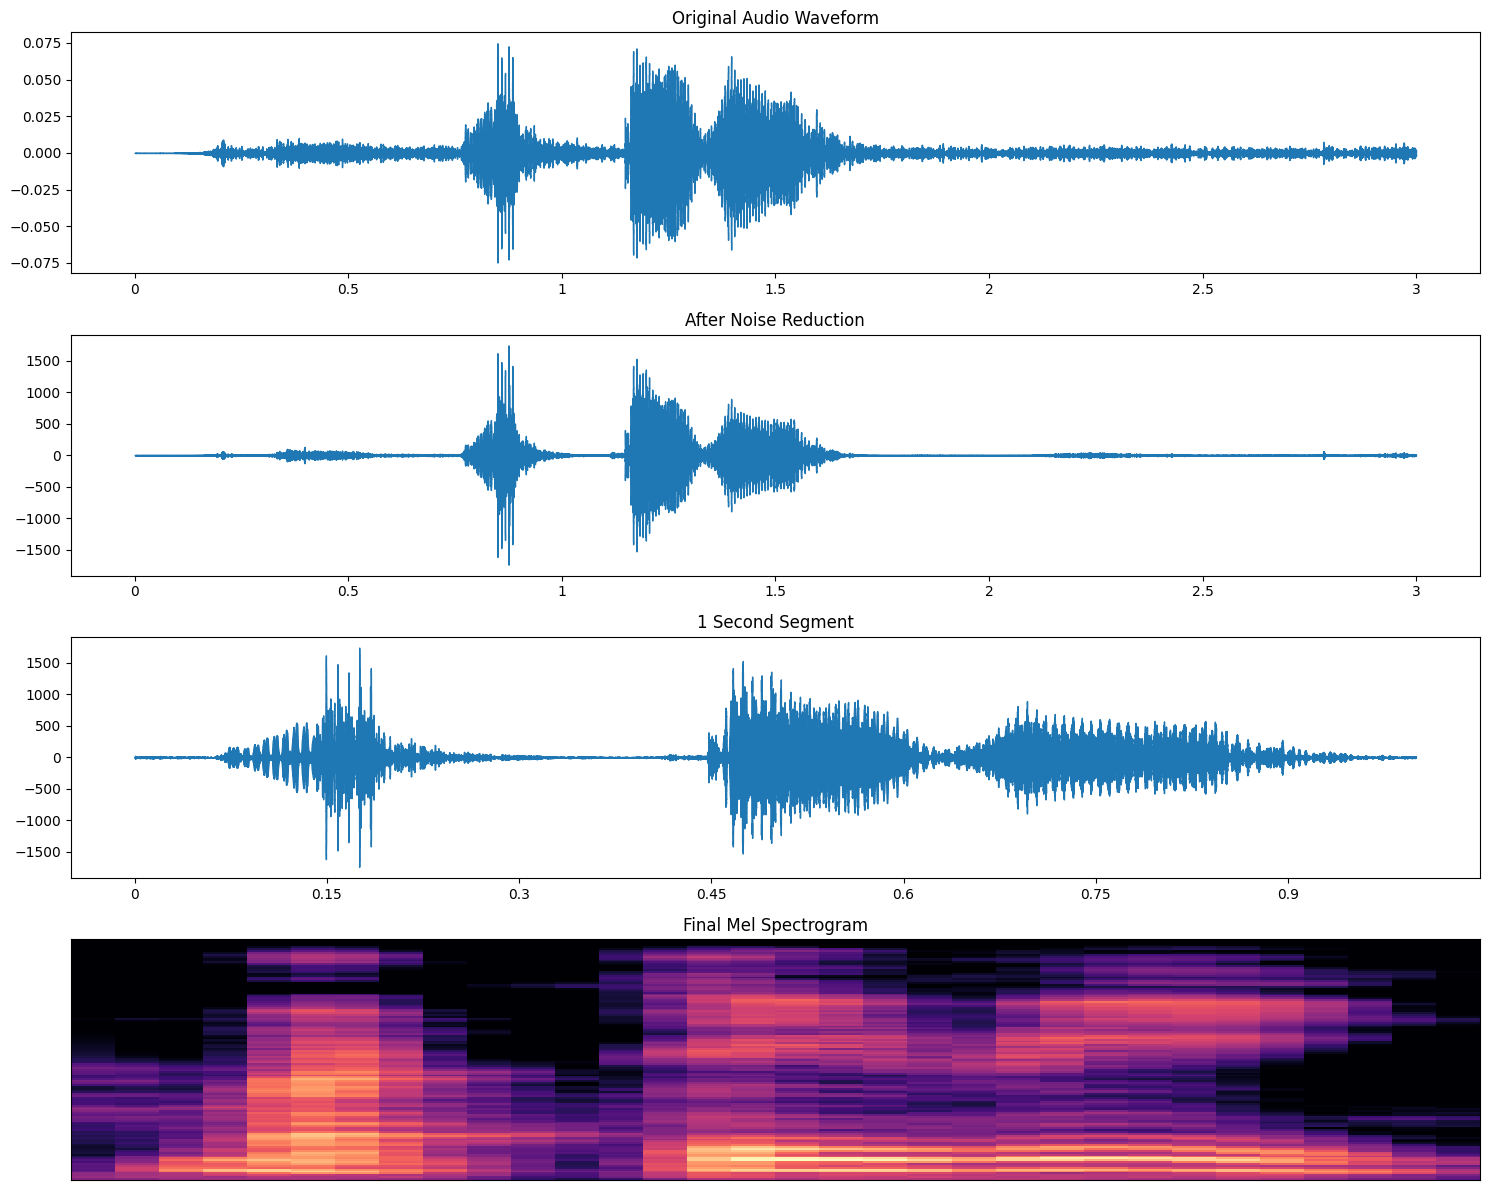

File: ../data/raw/bat_tv/bat_tv_speaker01_001.wav
Original duration: 3.00s
Final duration: 1.00s
Sample rate: 16000Hz

Energy analysis:
Original energy: 5224973312.00
Final energy: 424020082688.00
Energy ratio (Final/Original): 81.15

Visualizing processing steps for: do_am


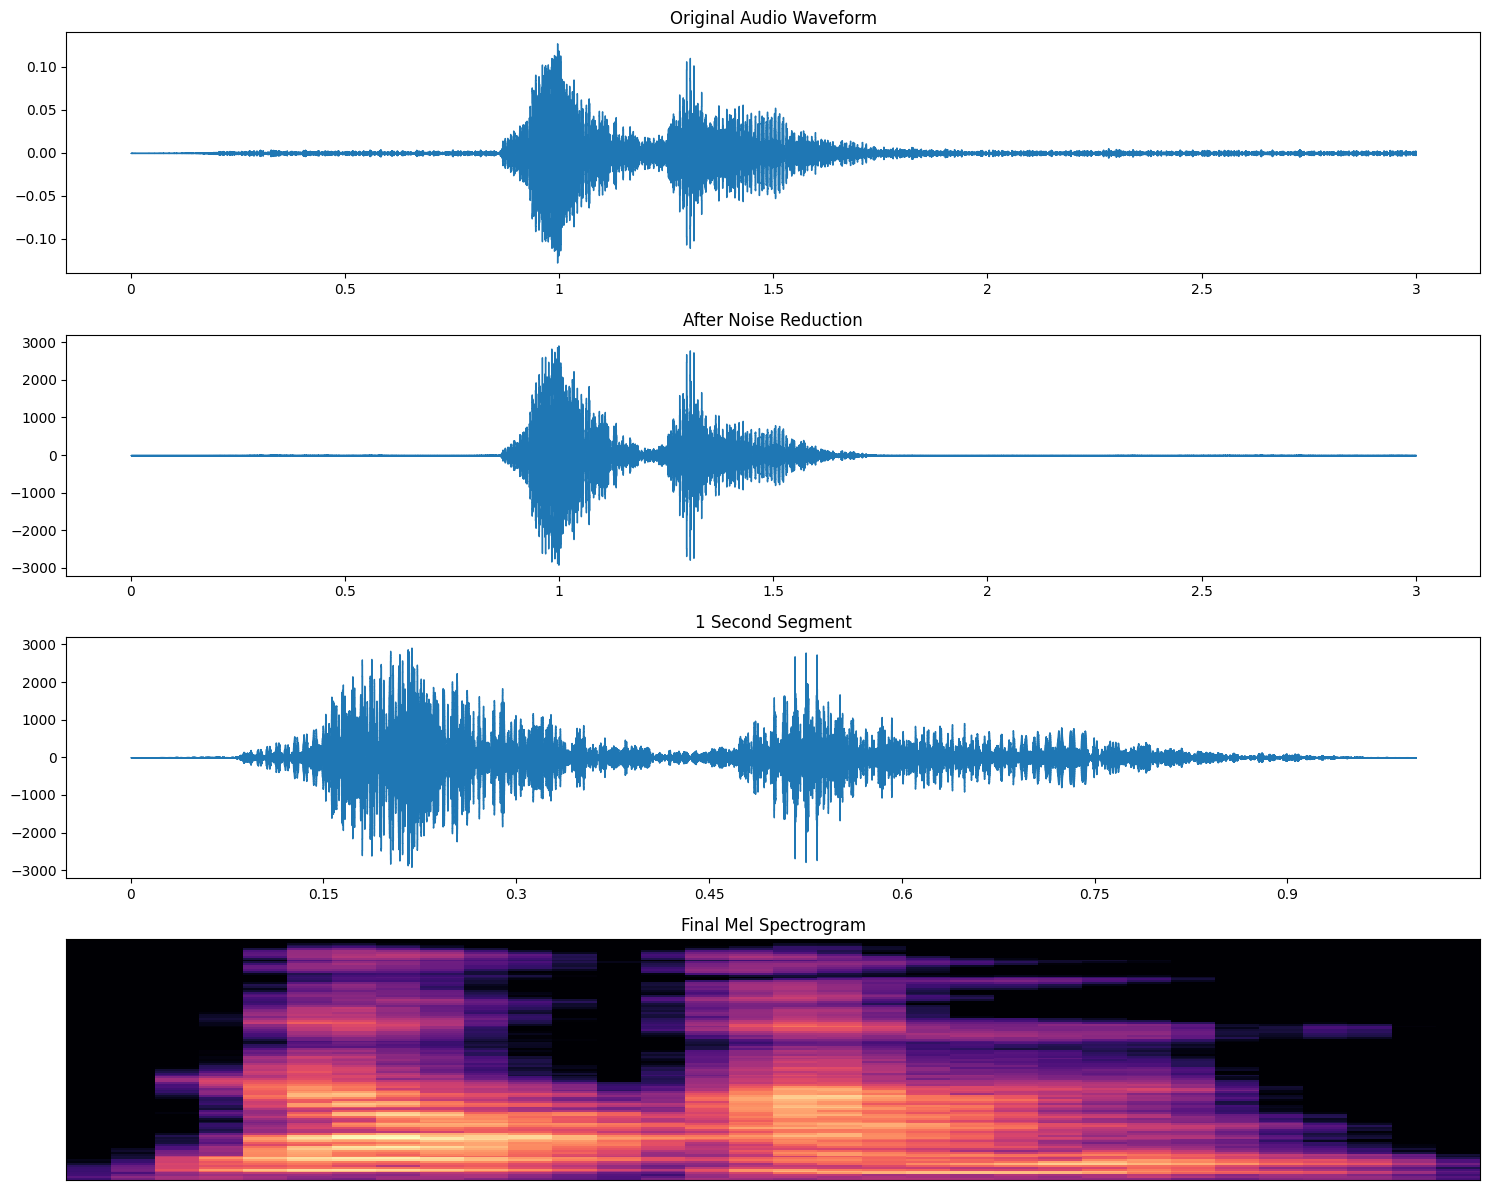

File: ../data/raw/do_am/do_am_speaker01_001.wav
Original duration: 3.00s
Final duration: 1.00s
Sample rate: 16000Hz

Energy analysis:
Original energy: 8407314432.00
Final energy: 462589722624.00
Energy ratio (Final/Original): 55.02

Visualizing processing steps for: dong_rem


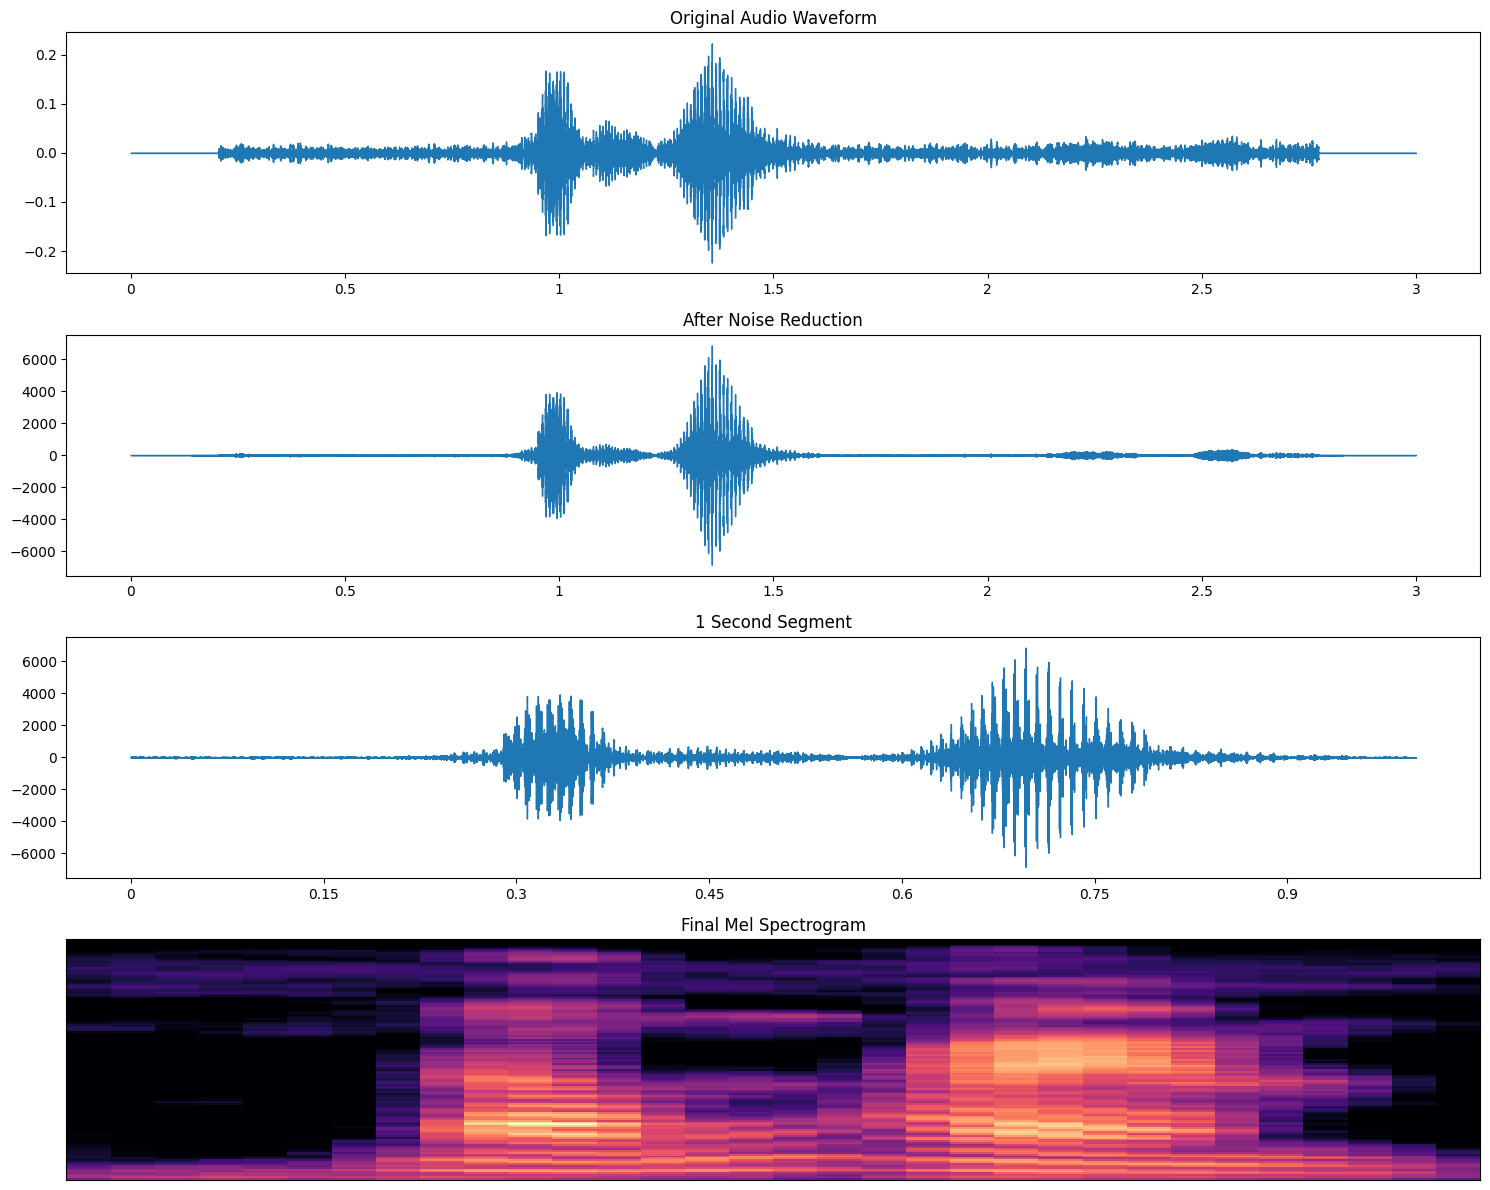

File: ../data/raw/dong_rem/dong_rem_speaker01_001.wav
Original duration: 3.00s
Final duration: 1.00s
Sample rate: 16000Hz

Energy analysis:
Original energy: 16366075904.00
Final energy: 161278476288.00
Energy ratio (Final/Original): 9.85

Visualizing processing steps for: mo_rem


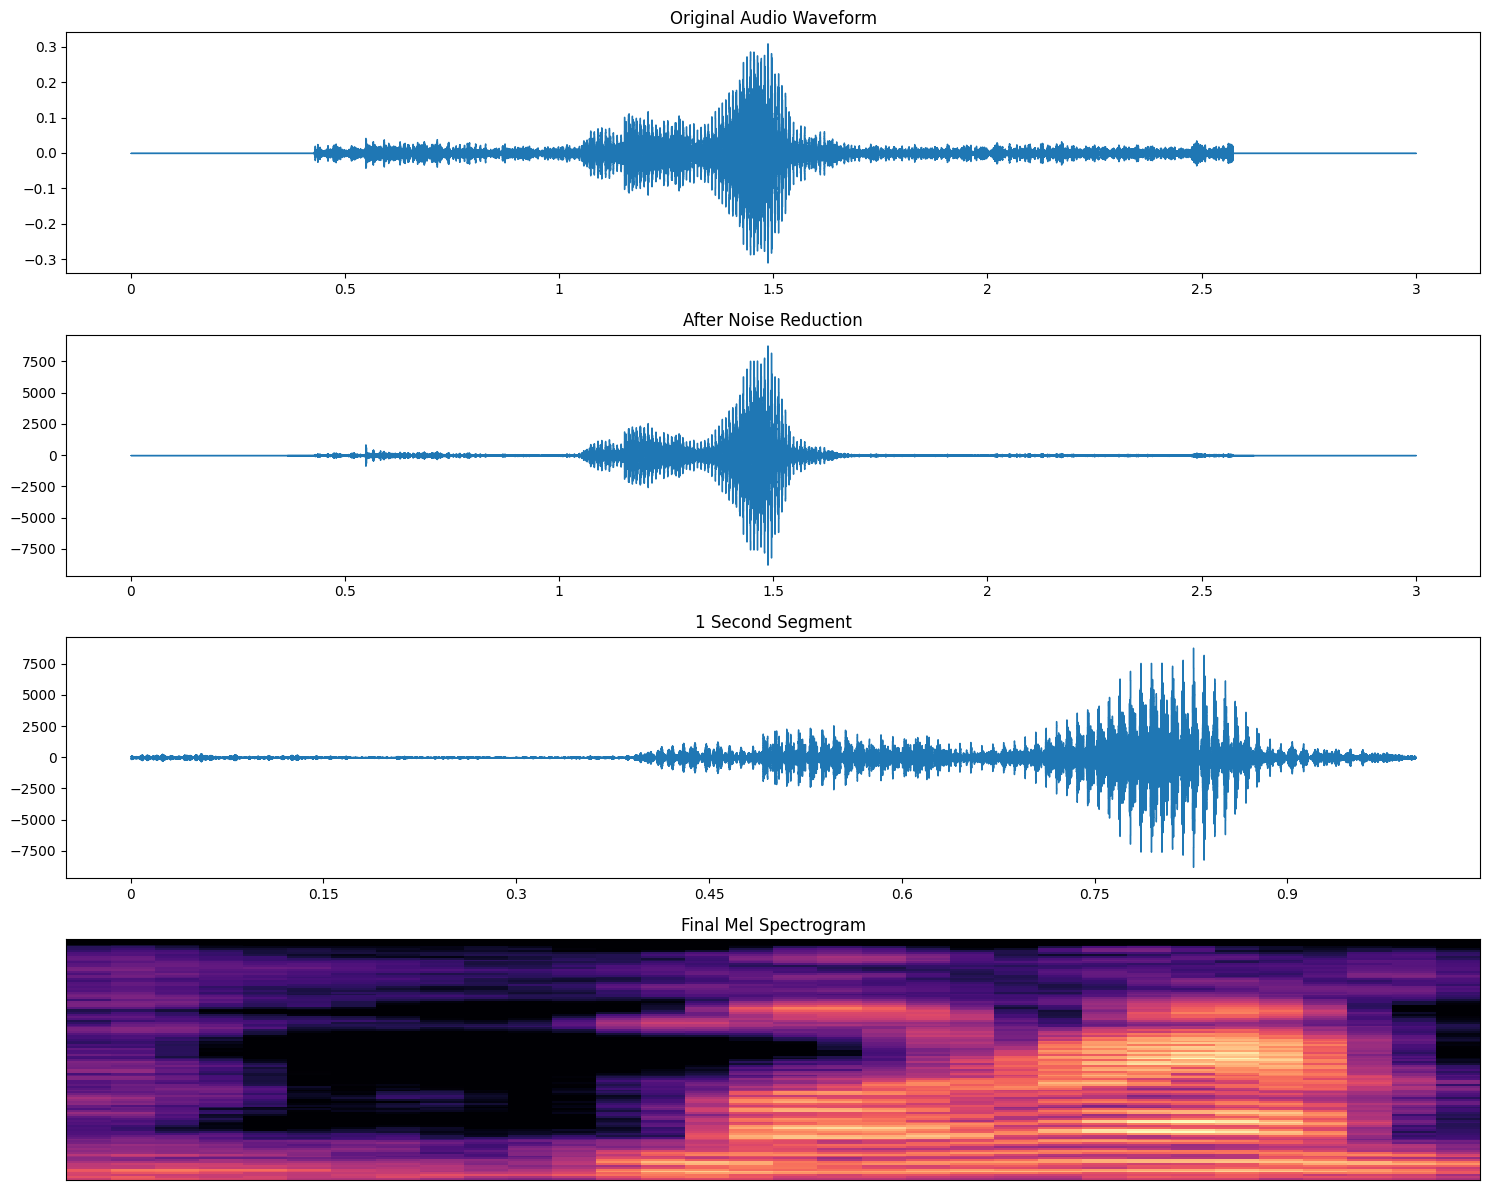

File: ../data/raw/mo_rem/mo_rem_speaker01_001.wav
Original duration: 3.00s
Final duration: 1.00s
Sample rate: 16000Hz

Energy analysis:
Original energy: 27841640448.00
Final energy: 150529228800.00
Energy ratio (Final/Original): 5.41

Visualizing processing steps for: nhiet_do


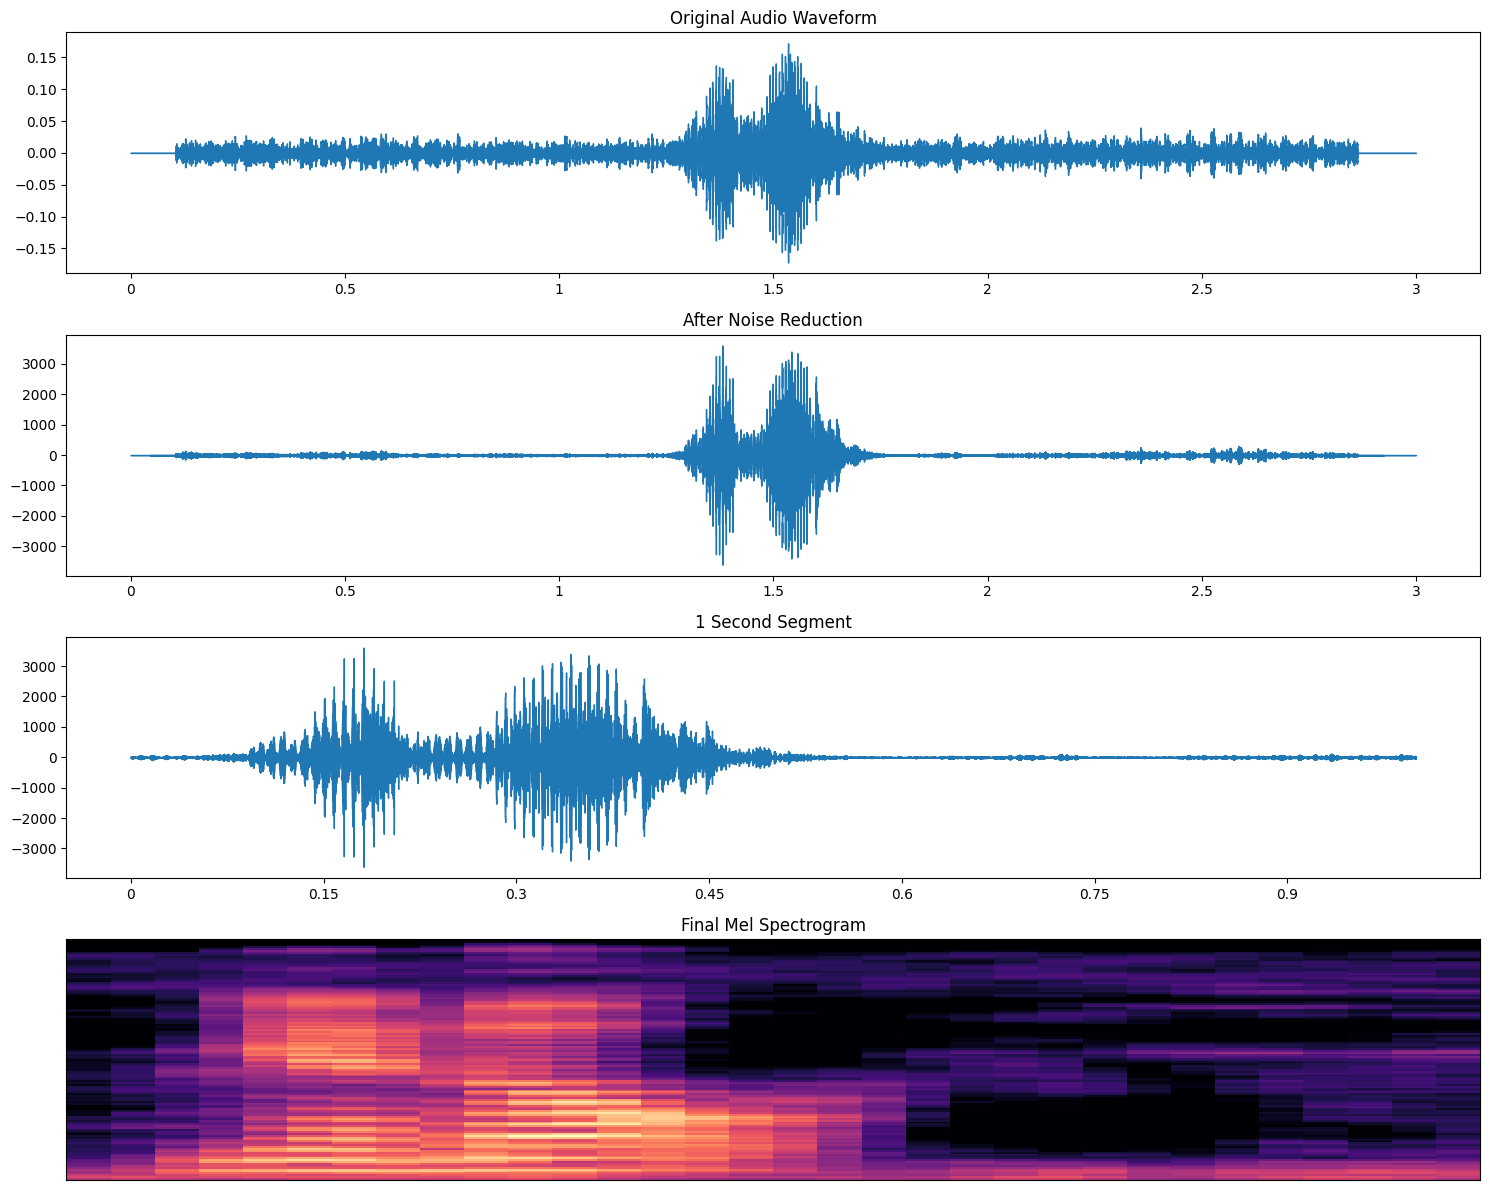

File: ../data/raw/nhiet_do/nhiet_do_speaker01_001.wav
Original duration: 3.00s
Final duration: 1.00s
Sample rate: 16000Hz

Energy analysis:
Original energy: 14872062976.00
Final energy: 300801490944.00
Energy ratio (Final/Original): 20.23

Visualizing processing steps for: tat_den


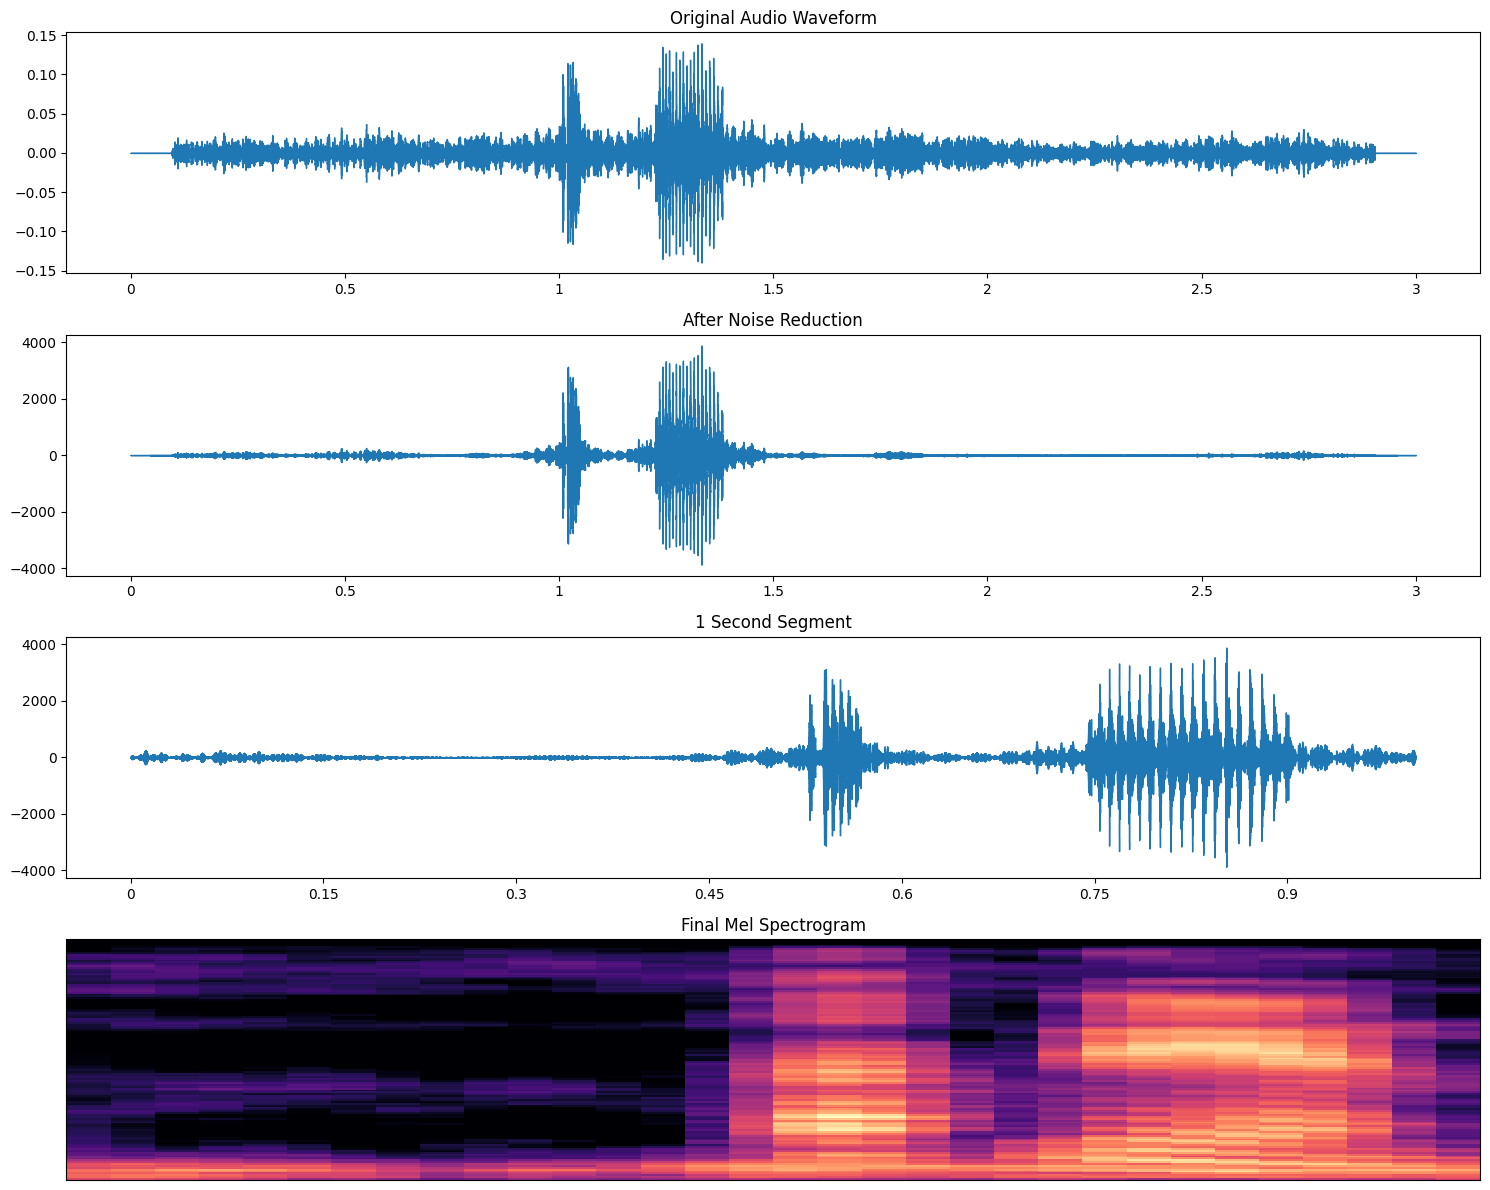

File: ../data/raw/tat_den/tat_den_speaker01_001.wav
Original duration: 3.00s
Final duration: 1.00s
Sample rate: 16000Hz

Energy analysis:
Original energy: 9522368512.00
Final energy: 200566325248.00
Energy ratio (Final/Original): 21.06

Visualizing processing steps for: tat_dieu_hoa


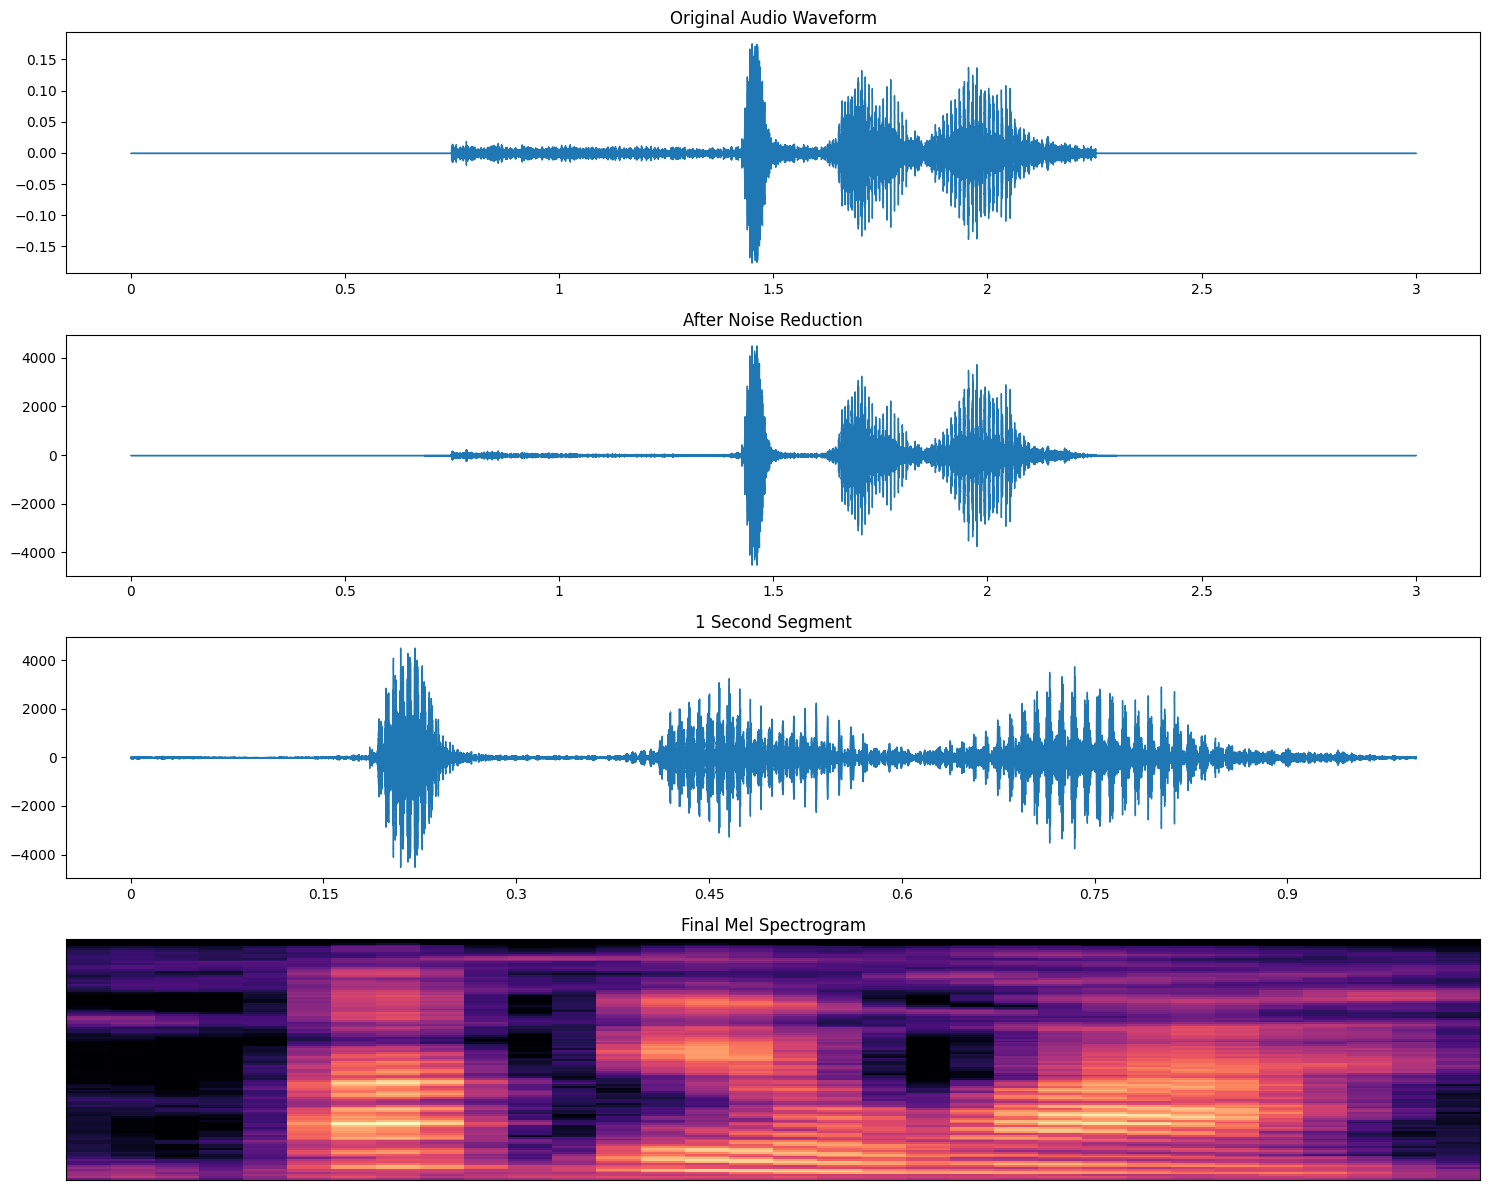

File: ../data/raw/tat_dieu_hoa/tat_dieu_hoa_speaker01_001.wav
Original duration: 3.00s
Final duration: 1.00s
Sample rate: 16000Hz

Energy analysis:
Original energy: 11820365824.00
Final energy: 288428785664.00
Energy ratio (Final/Original): 24.40

Visualizing processing steps for: tat_quat


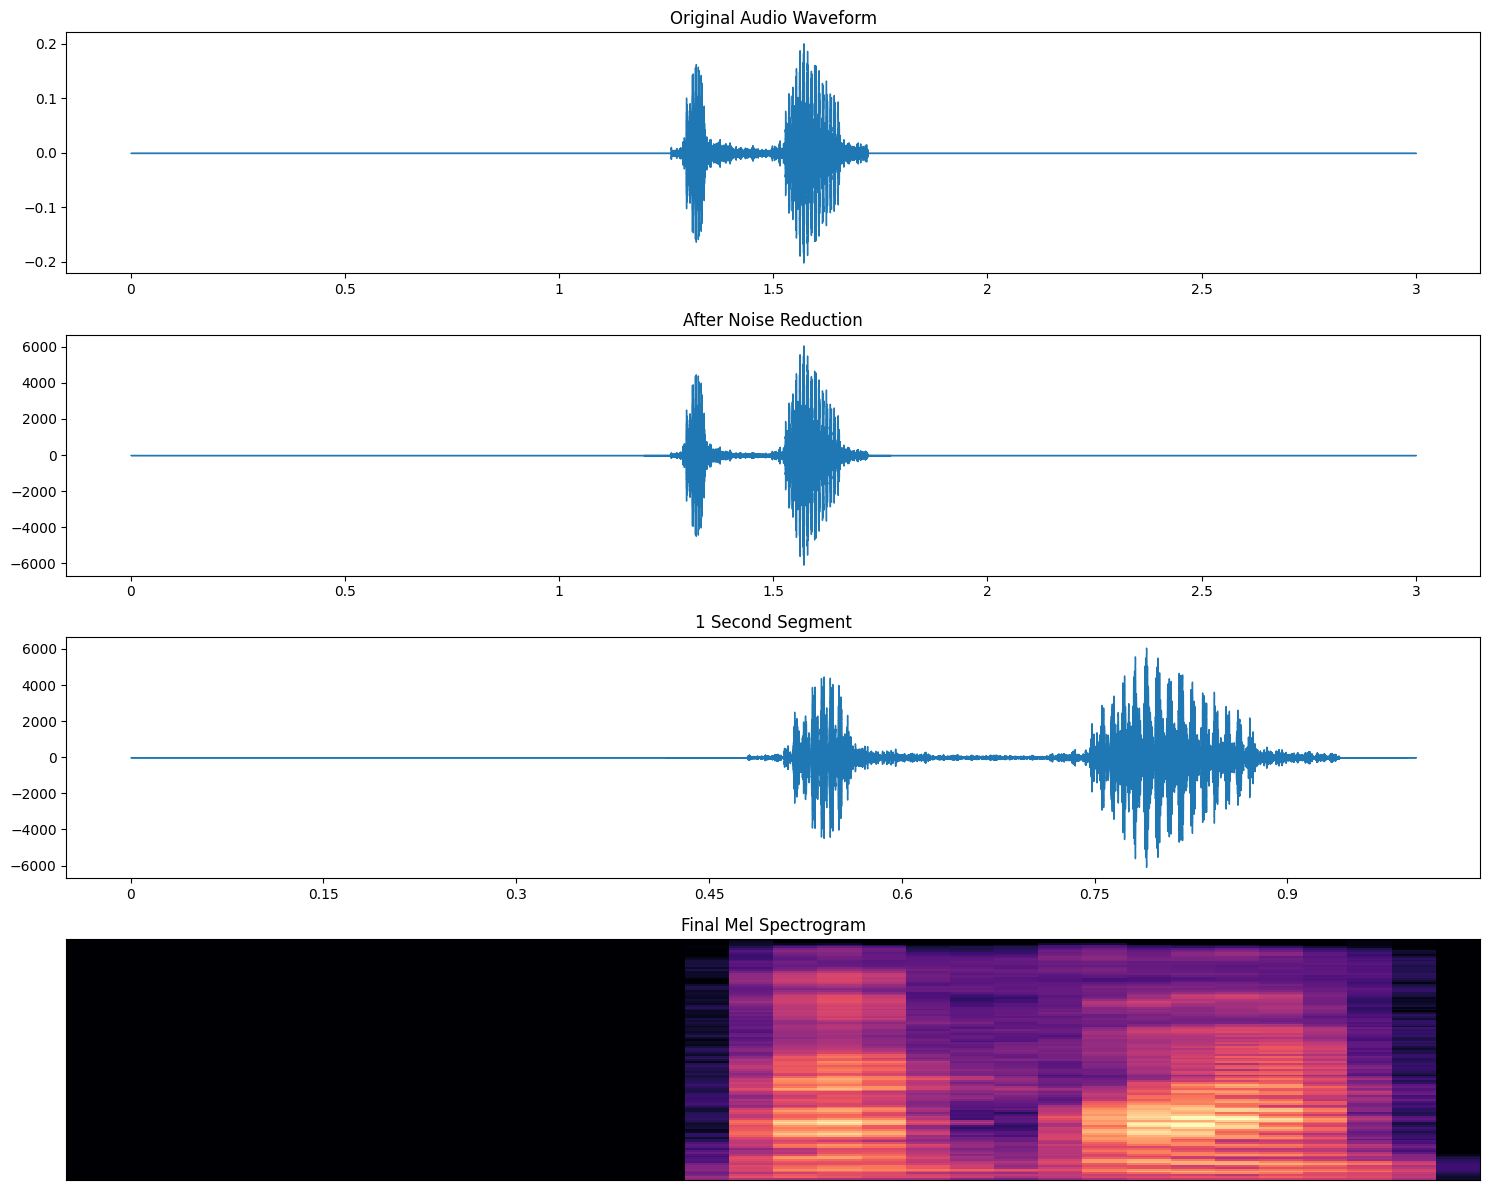

File: ../data/raw/tat_quat/tat_quat_speaker01_001.wav
Original duration: 3.00s
Final duration: 1.00s
Sample rate: 16000Hz

Energy analysis:
Original energy: 10816209920.00
Final energy: 224536576000.00
Energy ratio (Final/Original): 20.76

Visualizing processing steps for: tat_tv


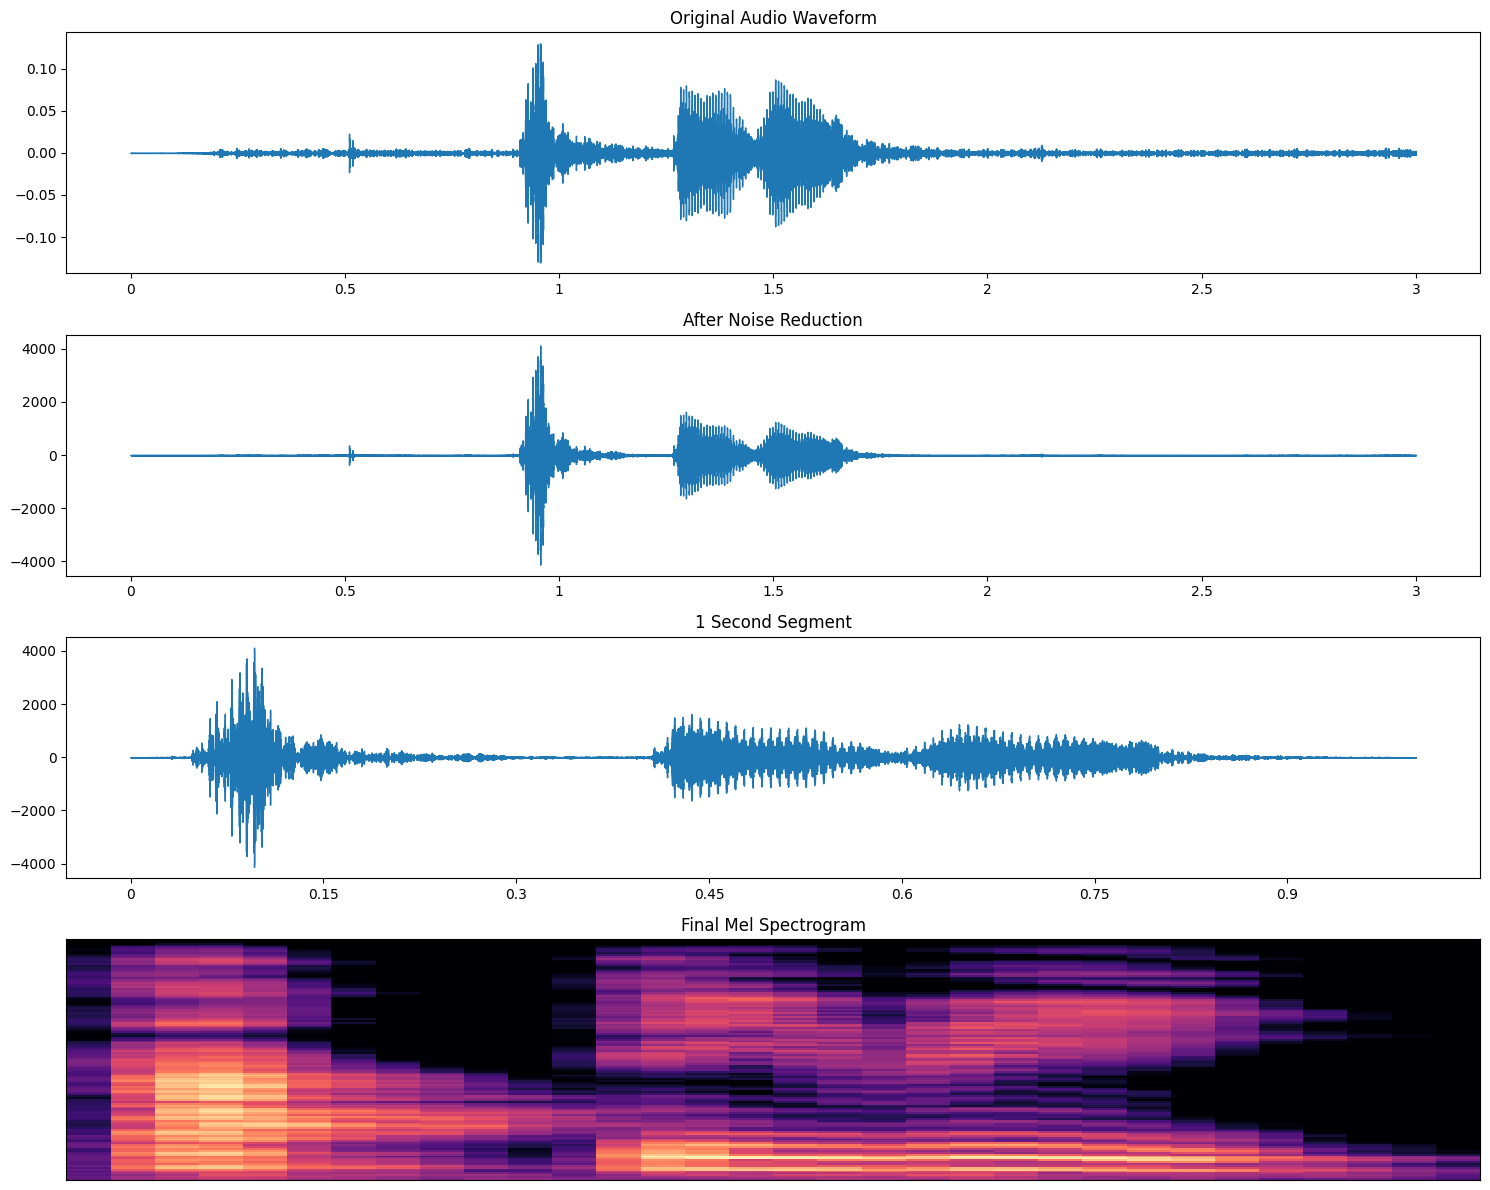

File: ../data/raw/tat_tv/tat_tv_speaker01_001.wav
Original duration: 3.00s
Final duration: 1.00s
Sample rate: 16000Hz

Energy analysis:
Original energy: 7895862784.00
Final energy: 163917316096.00
Energy ratio (Final/Original): 20.76


In [15]:
raw_dir = "../data/raw"

for command_dir in os.listdir(raw_dir):
    command_path = os.path.join(raw_dir, command_dir)
    if not os.path.isdir(command_path):
        continue
        
    wav_files = [f for f in os.listdir(command_path) if f.endswith('.wav')]
    if wav_files:
        input_path = os.path.join(command_path, wav_files[0])
        print(f"\nVisualizing processing steps for: {command_dir}")
        visualize_processing_steps(input_path)

Mục đích của notebook này là:
1. Tiền xử lý âm thanh để chuẩn hóa dữ liệu
2. Giảm nhiễu và trích xuất đoạn âm thanh có chất lượng tốt nhất
3. Hiển thị trực quan quá trình xử lý để kiểm tra chất lượng
4. Chuẩn bị dữ liệu cho các bước xử lý tiếp theo